# MOBILE APP DE RECOMMANDATION DE CONTENUS

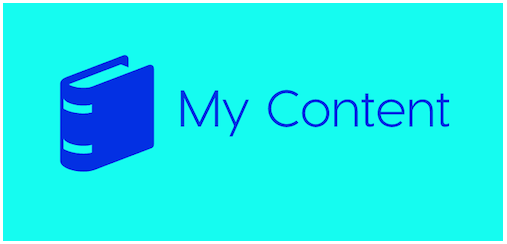

Notre start-up a pour but d'encourager la lecture en recommandant des contenus pertinents pour ses utilisateurs.

Nous allons dans un premier temps mettre en place un modèle qui pourra predire des recommandations de contenus. Nous allons voir la recommandation basée sur le contenu du produit, le Content-Based Filtering, puis la recommandation basée sur les interactions de l'utilisateur avec le contenu, le Collaborative Filtering.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import tensorflow as tf
import os
from time import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

import umap
import plotly.express as px
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

from tqdm import tqdm


from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, ndcg_at_k, AUC_at_k

In [2]:
articles = pd.read_csv("data/articles_metadata.csv",
                       parse_dates=["created_at_ts"],
                       date_parser=lambda x: datetime.fromtimestamp(int(x) // 1000))

list_csv = os.listdir('data/clicks/')
clicks = pd.concat([pd.read_csv(f'data/clicks/{file}',
                                parse_dates=["session_start", "click_timestamp"],
                                date_parser=lambda x: datetime.fromtimestamp(int(x) // 1000))
                    for file in list_csv], axis=0)

## I) EDA

In [3]:
articles_copy = articles.copy()
clicks_copy = clicks.copy()

### 1.1) Analysons les données des articles

In [4]:
articles_copy.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,2017-12-13 05:53:39,0,168
1,1,1,2014-07-14 13:45:36,0,189
2,2,1,2014-08-22 01:35:06,0,250
3,3,1,2014-08-19 18:11:53,0,230
4,4,1,2014-08-03 14:06:11,0,162


In [5]:
print("Dimension du dataset:", articles.shape)
print("Nombre d'article id unique:", len(articles.article_id.unique()))
print("Nombre de categorie:", len(articles.category_id.unique()))
print("Nombre de maison d'éditions unique:", len(articles.publisher_id.unique()))
print("Nombre de mots en moyen:", round(np.mean(articles.words_count)))

Dimension du dataset: (364047, 5)
Nombre d'article id unique: 364047
Nombre de categorie: 461
Nombre de maison d'éditions unique: 1
Nombre de mots en moyen: 191


In [6]:
top_20_categories = articles_copy.groupby(articles_copy.category_id).count().sort_values(by=['article_id'], ascending=False).iloc[:20].reset_index()
top_20_words_cat = articles_copy.groupby(articles_copy.category_id).mean().sort_values(by=['words_count'], ascending=False).iloc[:20].reset_index()
top_20_words_article = articles_copy.sort_values(by=['words_count'], ascending=False).iloc[:20]

articles_copy['year'] = articles_copy.created_at_ts.apply(lambda x: x.year)
created_date = articles_copy.groupby(articles_copy.year).count().reset_index()

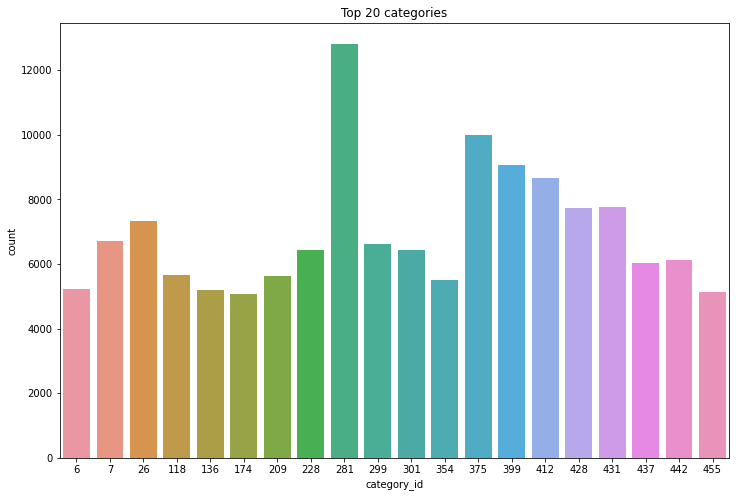

In [7]:
plt.figure(figsize=(12,8))
sns.barplot(x="category_id", y="article_id", data=top_20_categories)
plt.ylabel("count")
plt.title("Top 20 categories")
plt.show()

La catégorie 281 est la catégorie où l'on dénombre le plus de contenus sur le sujet.

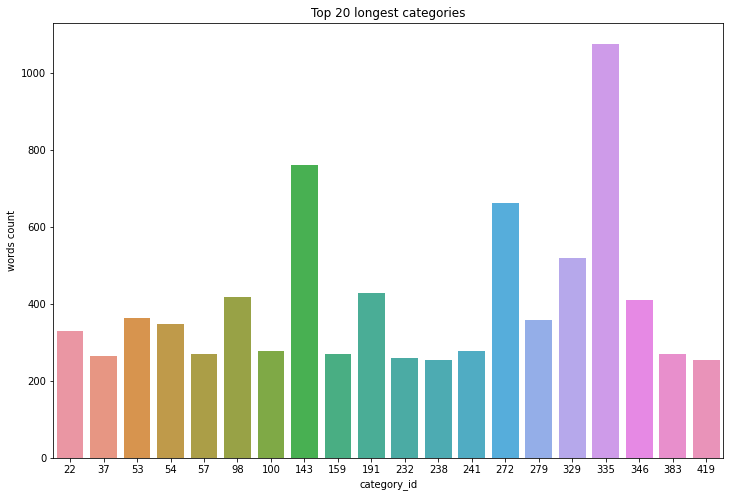

In [8]:
plt.figure(figsize=(12,8))
sns.barplot(x="category_id", y="words_count", data=top_20_words_cat)
plt.ylabel("words count")
plt.title("Top 20 longest categories")
plt.show()

La catégorie 335 est la catégoie ayant en moyenne des articles les plus long en terme de mots.

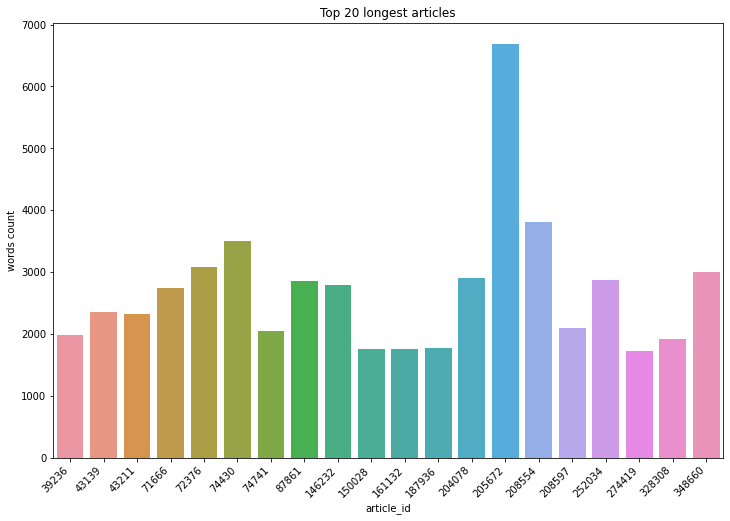

In [9]:
plt.figure(figsize=(12,8))
sns.barplot(x="article_id", y="words_count", data=top_20_words_article)
plt.ylabel("words count")
plt.title("Top 20 longest articles")
plt.xticks(rotation=45, ha='right')
plt.show()

L'article 205672 est l'article le plus long de toutes les données.

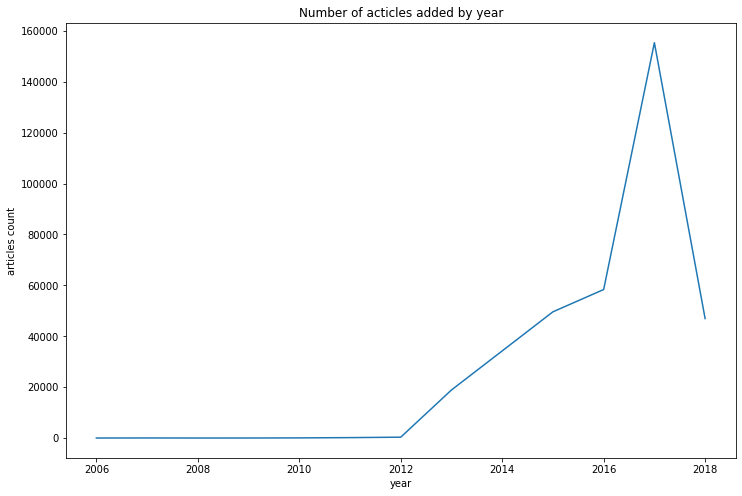

In [10]:
plt.figure(figsize=(12,8))
sns.lineplot(data=created_date, x="year", y="article_id")
plt.ylabel("articles count")
plt.title("Number of acticles added by year")
plt.show()

La plupart des articles ont été ajoutés entre 2016 et 2018.

### 1.2) Analysons les données des clicks (interaction entre l'utilisateur et les articles)

In [11]:
clicks_copy.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,2017-10-01 03:37:03,2,157541,2017-10-01 04:00:28,4,3,20,1,20,2
1,0,1506825423271737,2017-10-01 03:37:03,2,68866,2017-10-01 04:00:58,4,3,20,1,20,2
2,1,1506825426267738,2017-10-01 03:37:06,2,235840,2017-10-01 04:03:37,4,1,17,1,16,2
3,1,1506825426267738,2017-10-01 03:37:06,2,96663,2017-10-01 04:04:07,4,1,17,1,16,2
4,2,1506825435299739,2017-10-01 03:37:15,2,119592,2017-10-01 04:04:50,4,1,17,1,24,2


In [12]:
print("Dimension du dataset:", clicks_copy.shape)
print("Nombre d'user id unique:", len(clicks_copy.user_id.unique()))
print("Nombre de session id unique:", len(clicks_copy.session_id.unique()))
print("Nombre de session size unique:", len(clicks_copy.session_size.unique()))
print("Nombre de clic environnement unique:", len(clicks_copy.click_environment.unique()))
print("Nombre de clic device groupe unique:", len(clicks_copy.click_deviceGroup.unique()))
print("Nombre de clic os unique:", len((clicks_copy.click_os.unique())))
print("Nombre de clic country unique:", len(clicks_copy.click_country.unique()))
print("Nombre de clic region unique:", len(clicks_copy.click_region.unique()))
print("Nombre de clic refferer type unique:", len(clicks_copy.click_referrer_type.unique()))

Dimension du dataset: (2988181, 12)
Nombre d'user id unique: 322897
Nombre de session id unique: 1048594
Nombre de session size unique: 72
Nombre de clic environnement unique: 3
Nombre de clic device groupe unique: 5
Nombre de clic os unique: 8
Nombre de clic country unique: 11
Nombre de clic region unique: 28
Nombre de clic refferer type unique: 7


In [13]:
top_20_articles = clicks_copy.groupby(clicks_copy.click_article_id).count().sort_values(by=['user_id'], ascending=False).iloc[:20].reset_index()

In [14]:
clicks_copy.groupby(clicks_copy.user_id).sum().sort_values(by=['session_size'], ascending=False).iloc[:20].reset_index()

,user_id,session_id,session_size,click_article_id,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,73574,1415548763610046638,78551,182383581,3756,945,15918,939,23475,3618
1,80350,1180389857758297250,40481,164493692,3132,783,13311,783,16443,839
2,5890,1857203936664920749,39452,203082844,4928,1232,20944,1232,9871,2532
3,9261,661836776350544119,32551,75580064,1756,439,7463,439,3512,491
4,15275,1124593763659023084,25474,76513901,2984,746,12682,7460,20888,746
5,34541,755295067385951946,15875,97220162,2004,501,8517,501,12525,651
6,2151,1088427992473725492,13344,135966039,2888,736,12255,722,15098,1506
7,48723,679816967594974960,10777,87280498,1804,451,7667,451,11275,539
8,57221,633145554114708849,10224,41995139,1680,420,7140,420,2100,459
9,72093,413040371603767036,9812,47547734,1096,274,4658,274,3562,342


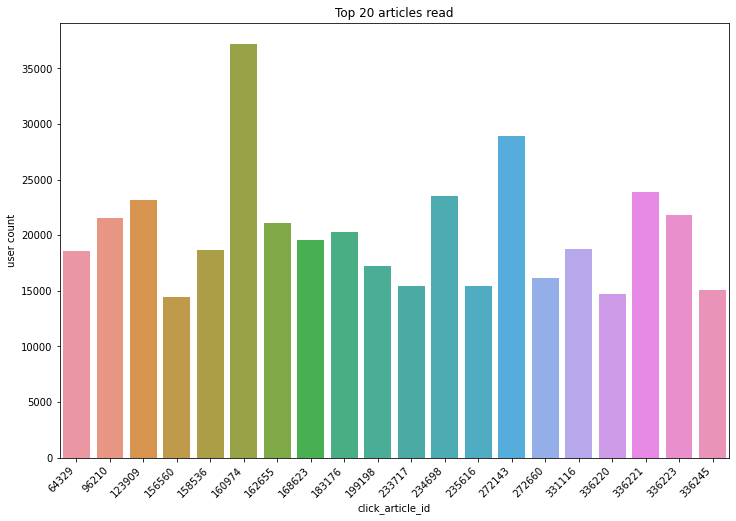

In [315]:
plt.figure(figsize=(12,8))
sns.barplot(x="click_article_id", y="user_id", data=top_20_articles)
plt.ylabel("user count")
plt.title("Top 20 articles read")
plt.xticks(rotation=45, ha='right')
plt.show()

L'article 160974 est l'article qui a été le plus lu.

## II) Content-Based Filtering

La recommandation par le contenu est le fait de recommander un produit à l'utilisateur en se basant sur un article qu'il a déja lu et en cherchant des articles qui sont similaires à cet article en question.

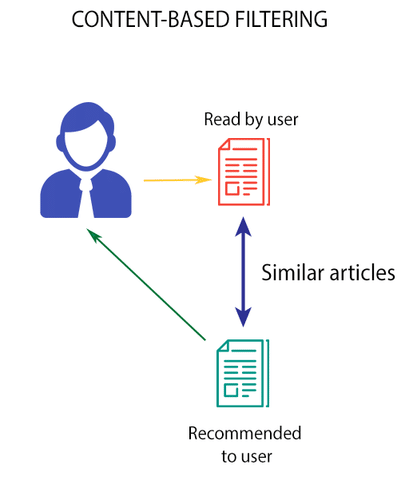

Contruisant la matrice qui va nous permettre de calculer les articles similaires: utilisons la matrice TF-IDF des articles et les informations de chaque articles.

In [316]:
tfidf = pd.DataFrame(pd.read_pickle('data/articles_embeddings.pickle'),
                     columns=[f'embedding_{i}' for i in range(pd.read_pickle('data/articles_embeddings.pickle').shape[1])])
articles = pd.concat([articles,tfidf], axis=1)

Puis mettons en place une fonction qui va calculer la similarité entre les articles en ayant le choix de se baser sur le dernier article lu de l'utilisateur ou alors en se basant sur un article lu selectionné au hasard :

In [431]:
def tide_df(df, category):
    
    df_copy = df.drop(["article_id", "similarity"], axis=1, errors="ignore")
    df_copy.loc[df_copy.category_id != category, 'category_id'] = 0
    df_copy.loc[df_copy.category_id == category, 'category_id'] = 1
    df_copy.created_at_ts = df_copy.created_at_ts.values.astype(np.int64) // 10 ** 9
    
    return df_copy

def compute_simularity(articles, clicks, user_id, n=5, mode="last"):
    
    if mode == "last":
        clicked_article_id = clicks[clicks.user_id== user_id].sort_values("click_timestamp", ascending=False).reset_index(drop=True).iloc[0]["click_article_id"]
    elif mode == "random":
        clicked_article_id = clicks[clicks.user_id== user_id].sample().iloc[0]["click_article_id"]
        
    article_selected_data = articles[articles.article_id == clicked_article_id]
    article_selected_category_id = article_selected_data.category_id.iloc[0]
    
    scaler = StandardScaler()
    articles_std = scaler.fit_transform(tide_df(articles, article_selected_category_id))
    article_selected_data_std = scaler.transform(tide_df(article_selected_data, article_selected_category_id))
    
    articles_copy = articles.copy()
    articles_copy["similarity"] = cosine_similarity(article_selected_data_std, articles_std)[0]
    articles_similar = articles_copy.sort_values("similarity", ascending=False).iloc[:n+1]
    articles_similar_std = scaler.transform(tide_df(articles_similar.iloc[1:].reset_index(drop=True), article_selected_category_id))
    
    return (articles_std,
            article_selected_data_std,
            article_selected_data,
            articles_similar_std,
            articles_similar)

Demandons une recommandation de 5 articles pour l'utilisateur 10, en se basant sur un article au hasard qu'il a lu :

In [469]:
user_id = 10

(articles_std,
 article_selected_data_std,article_selected_data,
 articles_similarity_std,articles_similarity) = compute_simularity(articles, clicks, user_id, n=5, mode="random")

In [470]:
umap_emb = umap.UMAP()

idx = np.random.randint(articles_std.shape[0], size=10000)
articles_sample = articles_std[idx, :]
articles_umap = umap_emb.fit_transform(np.concatenate([articles_sample,articles_similarity_std, article_selected_data_std]))
articles_similarity_umap = articles_umap[-len(articles_similarity_std)-1:-1]
articles_selected_umap = articles_umap[-1:]

In [471]:
articles_similarity

,article_id,category_id,created_at_ts,publisher_id,words_count,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,...,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,similarity
195689,195689,317,2017-02-21 06:18:11,0,240,-0.176309,-0.970299,-0.185773,-0.078684,-0.143442,...,0.342560,0.408708,-0.793811,0.606954,0.457178,0.502316,0.797318,-0.057217,0.330681,1.000000
194284,194284,317,2017-02-22 06:15:11,0,194,-0.062376,-0.969527,0.398492,0.152158,-0.065156,...,-0.121111,0.100623,-0.616313,0.520699,-0.028757,0.622681,0.549613,0.291086,0.117046,0.887175
195829,195829,317,2017-02-19 10:12:45,0,214,0.058985,-0.970177,0.666483,-0.408748,0.254534,...,-0.327000,0.211836,-0.179857,-0.328015,0.059202,0.708271,0.503329,0.223159,-0.000092,0.817684
195308,195308,317,2017-05-03 22:05:44,0,249,-0.129564,-0.978127,0.726907,0.279880,0.130452,...,-0.010231,0.853060,-0.869627,0.338577,-0.392312,0.585071,0.886503,0.261760,0.015566,0.795052
195566,195566,317,2017-03-26 18:09:28,0,258,-0.519752,-0.973712,0.115434,-0.067400,-0.194344,...,-0.397048,0.448330,-0.862914,0.839044,0.174379,0.473135,0.542323,0.125071,0.470722,0.785102
192515,192515,317,2014-04-01 08:43:41,0,219,0.263054,-0.963258,0.663239,0.450112,-0.224409,...,-0.163658,0.673871,-0.259074,0.444871,0.207115,0.165444,0.632095,0.074456,0.285371,0.770578


Le système lui recommande des articles les plus similaires à l'article 195689 (choisit au hasard).

Affichons les sur un plan 2D :

In [472]:
# Plot the data in the t-SNE space
fig = px.scatter(
    x=articles_umap[:-len(articles_similarity_std)-1, 0],
    y=articles_umap[:-len(articles_similarity_std)-1, 1],
    color=articles.loc[idx, "category_id"],
    title="UMAP 2D",
    opacity=0.3,
)

fig.add_scatter(
    x=articles_selected_umap[:, 0],
    y=articles_selected_umap[:, 1],
    mode="markers",
    marker=dict(color="green", size=30),
    text=f"Acticles selected \n user_id: {user_id} \n category_id: {article_selected_data['category_id'].iloc[0]}",
)

fig.add_scatter(
    x=articles_similarity_umap[:, 0],
    y=articles_similarity_umap[:, 1],
    mode="markers",
    marker=dict(color=list(range(len(articles_similarity_umap))), size=20),
    text=[
        f"rank: {i} / article_id: {a.article_id} / category_id: {a.category_id}"
        for i, a in enumerate(articles_similarity.iloc[1:,].itertuples())
    ],
)

fig.show()

## III)  Collaborative Filtering

Le Collaborative Filtering, se base sur les interactions entre les utilisateurs et les articles, et non plus sur les articles seulement. Si l'utilisateur 1 et l'utilisateur 2 ont lu le même article et l'ont tout deux aimé, et que l'utilisateur 2 a lu un autre article qu'il a aimé, tandis que l'utilisateur 1 n'a pas lu, le système va supposer que l'utilisateur 1 va aussi aimer, et donc lui recommander.
On est regarde plus la similarité des articles mais plutot la similarité des utilisateurs.

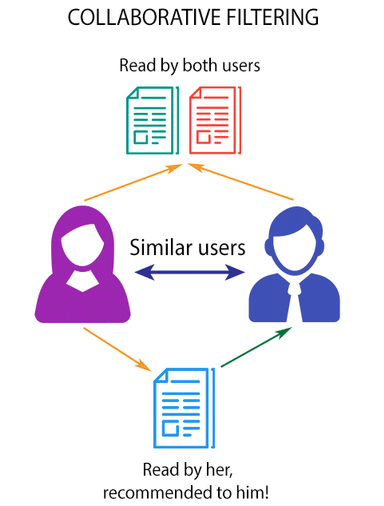

Il y a différentes approches pour l'évaluation des performances d'un model et différentes métriques pour chaque approche:
1. Métriques de Notation: Celles-ci sont utilisées pour évaluer la précision d'un système de recommandation à prédire des notes que les utilisateurs ont donnée aux produits
    * Root Mean Square Error (RMSE) - mesure de l'erreur moyenne des notes prédites
    * R Squared (R<sup>2</sup>) - essentiellment de combien est la variation total expliqué par le modèle
    * Mean Absolute Error (MAE) - similaire à RMSE mais utilise la valeur absolue plutot que le carré et la racine carré de la moyenne
    * Explained Variance - combien de variance dans les données est expliqué par le modèle
2. Métriques de Rang: Celles-ce sont utilisées pour évaluer comment sont interessantes les recommandations pour les utilisateurs
    * Precision - mesure la proportion de produits recommandés qui sont interessants
    * Recall - mesure la proportion de produit interessant qui sont recommandés
    * Normalized Discounted Cumulative Gain (NDCG) - évalue comment les produits sont recommandés pour un utilisateur sont bien rangé en se basant sur partinence
    * Mean Average Precision (MAP) - la moyenne de la precision pour chaque utilisateur normalisé sur tous les utilisateurs
3. Métriques non basées sur la precision: Celles-ci ne compare pas les prédictions avec les vraies valeurs mais plutôt évaluent les propriétés des recommandations suivantes :
    * Novelty - mesure comment sont les nouvelles recommandation de produits en calculant leur fréquence de recommandation parmi les utilisateurs 
    * Diversity - mesure comment sont différents les produits d'un ensemble les uns les autres
    * Serendipity - mesure comment sont surprenantes les recommandation faites pour un utilisateur spécifique en les comparant avec les produits avec lesquels l'utilisateur à déjà interagit
    * Coverage - mesure liée à la distribution des produits recommandés par le système 

Dans notre cas nous allons utiliser les métriques de rang, à savoir: Precision, NDCG et MAP.

Avant tout nous devant savoir si l'utilisateur a aimé ou non l'article qu'il a lu, pour celui il y a deux manière de le savoir:
1. De manière explicite: une note (binaire ou non)
2. De manière implcite: nombre de clics, temps passé sur la page, video joué jusqu'à la fin, article scrollé jusqu'à la fin, etc.

Dans notre cas nous allons utiliser une note implicite: le nombre de click par article pondéré par le nombre de click total par utilisateur.

In [5]:
clicks

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,2017-10-01 03:37:03,2,157541,2017-10-01 04:00:28,4,3,20,1,20,2
1,0,1506825423271737,2017-10-01 03:37:03,2,68866,2017-10-01 04:00:58,4,3,20,1,20,2
2,1,1506825426267738,2017-10-01 03:37:06,2,235840,2017-10-01 04:03:37,4,1,17,1,16,2
3,1,1506825426267738,2017-10-01 03:37:06,2,96663,2017-10-01 04:04:07,4,1,17,1,16,2
4,2,1506825435299739,2017-10-01 03:37:15,2,119592,2017-10-01 04:04:50,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2564,10051,1508211372158328,2017-10-17 04:36:12,2,84911,2017-10-17 04:39:17,4,3,2,1,25,1
2565,322896,1508211376302329,2017-10-17 04:36:16,2,30760,2017-10-17 04:41:12,4,1,17,1,25,2
2566,322896,1508211376302329,2017-10-17 04:36:16,2,157507,2017-10-17 04:41:42,4,1,17,1,25,2
2567,123718,1508211379189330,2017-10-17 04:36:19,2,234481,2017-10-17 04:38:33,4,3,2,1,25,2


Créons une fonction qui va calculer la note implicite :

In [49]:
def get_ratings(clicks):
    count_clicks_by_articles_by_user = clicks.groupby(["user_id", "click_article_id"]).agg(count_clicks_by_articles_by_user=("session_id", "count"))
    count_clicks_by_user = clicks.groupby(["user_id"]).agg(count_clicks_by_user=("session_id", "count"))

    clicks_count = count_clicks_by_articles_by_user.join(count_clicks_by_user, on="user_id")
    clicks_count['rating'] = clicks_count["count_clicks_by_articles_by_user"] / clicks_count["count_clicks_by_user"]
    ratings = clicks_count.reset_index().drop(["count_clicks_by_articles_by_user","count_clicks_by_user"], axis=1).rename(columns={"click_article_id":"article_id"})
    return ratings

In [50]:
ratings = get_ratings(clicks)
ratings

,user_id,article_id,rating
0,0,68866,0.125
1,0,87205,0.125
2,0,87224,0.125
3,0,96755,0.125
4,0,157541,0.125
...,...,...,...
2950705,322894,168401,0.500
2950706,322895,63746,0.500
2950707,322895,289197,0.500
2950708,322896,30760,0.500


Maintenant que nous avons la note pour chaque article que l'utilisateur à lu, nous allons simplement comparer différent modèle et garder le plus performant.

In [51]:
ratings_sample = ratings.sample(frac=0.1, random_state=31)

In [52]:
ratings_sample

,user_id,article_id,rating
2592422,226635,202355,0.090909
2458136,201967,48644,0.500000
694411,37592,315105,0.041667
674037,36082,84273,0.016393
96263,4028,265147,0.111111
...,...,...,...
634814,33328,208145,0.017544
385742,18180,272143,0.029412
2471821,204235,159938,0.090909
917853,50281,336223,0.013514


Divison le jeu en train et test :

In [53]:
train_df, test_df = train_test_split(ratings_sample, train_size=0.8, random_state=31)

In [109]:
def compute_models(train_df, test_df):
    
    df_results = pd.DataFrame(columns=['model', 'Precision@k','MAP@k','nDCG@k',"train_time", "recommend_time"])
    
    dim = (max(train_df.user_id.max(),test_df.user_id.max())+1, max(train_df.article_id.max(),test_df.article_id.max())+1)
    
    train_csr = csr_matrix((train_df['rating'], (train_df['user_id'], train_df['article_id'])), dim)
    test_csr = csr_matrix((test_df['rating'], (test_df['user_id'], test_df['article_id'])), dim)
    
    user_id = np.random.choice(train_df.user_id)
#     indexes = list(train_df.index)
#     user_idx = indexes.index(user_id)
    
    filter_ = clicks[clicks.user_id==user_id].click_article_id.tolist()[:10]
    

    for model in [AlternatingLeastSquares(),
                  BayesianPersonalizedRanking(),
                  LogisticMatrixFactorization()]:
        
        train_start_time = time()
        model.fit(train_csr)
        train_time = time() - train_start_time
        
        print("="*30)
        print(model.__class__.__name__)
        print(f"Articles read by user {user_id}:", filter_)
        
        #Get Recommendations
        recommend_start_time = time()
        recommended = model.recommend(user_id, train_csr[user_id], N=5)
        print(f"Articles recommended for user {user_id}:", recommended[0])
        recommend_time = time() - recommend_start_time
        
        precision_k = precision_at_k(model, train_csr, test_csr)
        map_at_k = mean_average_precision_at_k(model, train_csr, test_csr)
        ndcg_k = ndcg_at_k(model, train_csr, test_csr)
        print("Precision@k:", precision_k)
        print("MAP@k:", map_at_k)
        print("nDCG@k:", ndcg_k)
        print("="*30)
        
        df_results = df_results.append({
            'model': model.__class__.__name__,
            'Precision@k': round(precision_k,5),
            'MAP@k': round(map_at_k,5),
            'nDCG@k': round(ndcg_k,5),
            'train_time': round(train_time,5),
            'recommend_time': round(recommend_time,9),
        }, ignore_index=True)
        
    return df_results

In [110]:
compute_models(train_df, test_df)

100%|██████████| 15/15 [00:01<00:00,  8.76it/s]


AlternatingLeastSquares
Articles read by user 164416: [293301, 161439, 237524, 214393, 168623, 225019, 225416, 70591, 277492, 224354]
Articles recommended for user 164416: [313920 218028 276970  96210 289003]


100%|██████████| 47132/47132 [00:24<00:00, 1934.20it/s]


Precision@k: 0.03234725379109136
MAP@k: 0.011598941573621312
nDCG@k: 0.017138785007710877


100%|██████████| 100/100 [00:02<00:00, 41.46it/s, train_auc=95.53%, skipped=0.57%]


BayesianPersonalizedRanking
Articles read by user 164416: [293301, 161439, 237524, 214393, 168623, 225019, 225416, 70591, 277492, 224354]
Articles recommended for user 164416: [ 87211 207469  75962  72254 220165]


100%|██████████| 47132/47132 [00:24<00:00, 1942.98it/s]


Precision@k: 0.005020863724259592
MAP@k: 0.0018041126025881622
nDCG@k: 0.002602701528744251


100%|██████████| 30/30 [00:04<00:00,  6.89it/s]


LogisticMatrixFactorization
Articles read by user 164416: [293301, 161439, 237524, 214393, 168623, 225019, 225416, 70591, 277492, 224354]
Articles recommended for user 164416: [272143 158536 235230 156560 160417]


100%|██████████| 47132/47132 [00:24<00:00, 1939.27it/s]

Precision@k: 0.053736811751535093
MAP@k: 0.01776908792574891
nDCG@k: 0.027595492384077026


,model,Precision@k,MAP@k,nDCG@k,train_time,recommend_time
0,AlternatingLeastSquares,0.03235,0.01160,0.01714,2.28772,0.006000
1,BayesianPersonalizedRanking,0.00502,0.00180,0.00260,3.07904,0.005997
2,LogisticMatrixFactorization,0.05374,0.01777,0.02760,4.94594,0.002998


Le modèle le plus perfomant étant le LMF (Logistic Matric Factorization) avec 5,3% des articles recommandés par le système sont des articles pertinent pour l'utilisateur, donc qui est susceptible d'aimer.

## IV)  Sauvegarde des articles prédits dans une base de donnée

Afin de rendre la disponibilité des recommandations aux utilisateurs plus rapide, nous calculons par l'ensemble des utilisateurs les 5 articles qui sont les plus susceptibles d'être aimé et les stockons dans une base de donnée COMOSDB d'Azure.

In [160]:
from azure.cosmos import CosmosClient, PartitionKey
import os
from dotenv import load_dotenv
load_dotenv()

url = os.getenv("ACCOUNT_URI")
key = os.getenv("ACCOUNT_KEY")

Connectons nous à la base de données, ou créons la si elle n'existe pas :

In [161]:
client = CosmosClient(url, key, "Session")
database = client.create_database_if_not_exists(id="recommendations")
container = database.create_container_if_not_exists(
    id="UserArticles",
    partition_key=PartitionKey(path="/id"),
)

Mettons en place les données et le modèle :

In [162]:
ratings_s = ratings.sample(frac=0.005, random_state=31).reset_index(drop=True)
ratings_csr = csr_matrix((ratings_s['rating'], (ratings_s['user_id'], ratings_s['article_id'])))
user_ids = ratings_s["user_id"].unique().astype("int")

In [163]:
model = LogisticMatrixFactorization()
model.fit(ratings_csr)

100%|██████████| 30/30 [00:00<00:00, 42.61it/s]


Calculons pour l'ensemble des utilisateurs les 5 articles à leur recommander :

In [164]:
recommended, _ = model.recommend(user_ids, ratings_csr[user_ids], N=5)

Enregistrons les resultats dans la base de données :

In [166]:
for i, user_id in tqdm(enumerate(user_ids)):
    container.upsert_item(
        body={
            "id": str(i),
            "articles": [str(article_id) for article_id in recommended[i]],
        }
    )

13809it [1:09:55,  3.29it/s]


A présent l'application mobile à juste à envoyer des requêtes à la base de données pour récuperer les recommandations stockées.